In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from transformers import get_scheduler
from torch.optim import  AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
import sys

In [2]:
#FUNCIONES PERSONALIZADAS PARA LOS MODELOS
sys.path.append(os.path.abspath("../funciones"))

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DESDE EL MÓDULO
from funcionesEntrenamientoRoBERTa import (
    RobertaClassifier,
    generar_loader,
    obtener_probs,
    RANDOM_STATE,
    NUM_EPOCHS,
    KFOLDS,
    PATIENCE,
    TARGET_AUC,
    DEVICE,
)

from funcionesEntrenamiento import (
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
)

In [3]:
# establecer semilla
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [6]:
# Carga de datos
df_train = pd.read_csv("../../data/ds_BETO.csv")

In [6]:
# Training loop with cross-validation
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train["texto_bert"], df_train["class"])):
    print(f"\n----- Fold {fold+1} -----")

    train_texts = df_train.iloc[train_idx]["texto_bert"].tolist()
    train_labels = df_train.iloc[train_idx]["class"].tolist()
    val_texts = df_train.iloc[val_idx]["texto_bert"].tolist()
    val_labels = df_train.iloc[val_idx]["class"].tolist()

    train_loader = generar_loader(train_texts, train_labels, shuffle=True)
    val_loader = generar_loader(val_texts, val_labels)

    model = RobertaClassifier().to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = get_scheduler("linear", optimizer=optimizer,
                              num_warmup_steps=0,
                              num_training_steps=NUM_EPOCHS * len(train_loader))
    criterion = nn.BCEWithLogitsLoss()

    best_auc = 0
    patience_counter = 0

    train_loss_vals, val_auc_vals = [], []

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        train_loss_vals.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].cpu().numpy()
                outputs = model(input_ids, attention_mask)
                probs = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(probs)
                val_trues.extend(labels)

        val_auc = roc_auc_score(val_trues, val_preds)
        val_auc_vals.append(val_auc)
        print(f"Epoch {epoch+1}: Train Loss={train_loss_vals[-1]:.4f}, Val AUC={val_auc:.4f}")

        # Early stopping
        if val_auc > best_auc:
            best_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping.")
                break

              # Plot convergence
    plt.figure()
    plt.plot(train_loss_vals, label="Train Loss")
    plt.plot(val_auc_vals, label="Val AUC")
    plt.legend()
    plt.title(f"Fold {fold+1} - Training Progress")
    plt.savefig(f"fold{fold+1}_training_plot.png")
    plt.close()


----- Fold 1 -----


c:\Users\z47al\.conda\envs\ia_project\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\z47al\.cache\huggingface\hub\models--PlanTL-GOB-ES--roberta-base-bne. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta

Epoch 1: Train Loss=0.3972, Val AUC=0.9671


Epoch 2: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 2: Train Loss=0.1675, Val AUC=0.9684


Epoch 3: 100%|██████████| 75/75 [02:46<00:00,  2.21s/it]


Epoch 3: Train Loss=0.0896, Val AUC=0.9737


Epoch 4: 100%|██████████| 75/75 [02:44<00:00,  2.20s/it]


Epoch 4: Train Loss=0.0524, Val AUC=0.9735


Epoch 5: 100%|██████████| 75/75 [02:45<00:00,  2.20s/it]


Epoch 5: Train Loss=0.0238, Val AUC=0.9775


Epoch 6: 100%|██████████| 75/75 [03:07<00:00,  2.51s/it]


Epoch 6: Train Loss=0.0306, Val AUC=0.9757


Epoch 7: 100%|██████████| 75/75 [04:12<00:00,  3.37s/it]


Epoch 7: Train Loss=0.0098, Val AUC=0.9759


Epoch 8: 100%|██████████| 75/75 [02:50<00:00,  2.28s/it]


Epoch 8: Train Loss=0.0063, Val AUC=0.9758


Epoch 9: 100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch 9: Train Loss=0.0049, Val AUC=0.9757


Epoch 10: 100%|██████████| 75/75 [02:41<00:00,  2.16s/it]


Epoch 10: Train Loss=0.0041, Val AUC=0.9760
Early stopping.

----- Fold 2 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 1: Train Loss=0.4076, Val AUC=0.9451


Epoch 2: 100%|██████████| 75/75 [02:45<00:00,  2.20s/it]


Epoch 2: Train Loss=0.1648, Val AUC=0.9694


Epoch 3: 100%|██████████| 75/75 [02:44<00:00,  2.20s/it]


Epoch 3: Train Loss=0.1022, Val AUC=0.9575


Epoch 4: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 4: Train Loss=0.0555, Val AUC=0.9735


Epoch 5: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 5: Train Loss=0.0272, Val AUC=0.9695


Epoch 6: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 6: Train Loss=0.0158, Val AUC=0.9748


Epoch 7: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 7: Train Loss=0.0087, Val AUC=0.9696


Epoch 8: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 8: Train Loss=0.0064, Val AUC=0.9710


Epoch 9: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 9: Train Loss=0.0051, Val AUC=0.9714


Epoch 10: 100%|██████████| 75/75 [02:48<00:00,  2.24s/it]


Epoch 10: Train Loss=0.0041, Val AUC=0.9712


Epoch 11: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 11: Train Loss=0.0035, Val AUC=0.9713
Early stopping.

----- Fold 3 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:32<00:00,  2.04s/it]


Epoch 1: Train Loss=0.4165, Val AUC=0.9582


Epoch 2: 100%|██████████| 75/75 [02:35<00:00,  2.08s/it]


Epoch 2: Train Loss=0.1531, Val AUC=0.9690


Epoch 3: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it]


Epoch 3: Train Loss=0.0771, Val AUC=0.9713


Epoch 4: 100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


Epoch 4: Train Loss=0.0659, Val AUC=0.9732


Epoch 5: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it]


Epoch 5: Train Loss=0.0280, Val AUC=0.9722


Epoch 6: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it]


Epoch 6: Train Loss=0.0217, Val AUC=0.9664


Epoch 7: 100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


Epoch 7: Train Loss=0.0216, Val AUC=0.9698


Epoch 8: 100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


Epoch 8: Train Loss=0.0138, Val AUC=0.9474


Epoch 9: 100%|██████████| 75/75 [02:31<00:00,  2.03s/it]


Epoch 9: Train Loss=0.0054, Val AUC=0.9688
Early stopping.

----- Fold 4 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:47<00:00,  2.23s/it]


Epoch 1: Train Loss=0.4413, Val AUC=0.9583


Epoch 2: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 2: Train Loss=0.1987, Val AUC=0.9685


Epoch 3: 100%|██████████| 75/75 [02:47<00:00,  2.23s/it]


Epoch 3: Train Loss=0.0905, Val AUC=0.9697


Epoch 4: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 4: Train Loss=0.0553, Val AUC=0.9636


Epoch 5: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 5: Train Loss=0.0298, Val AUC=0.9648


Epoch 6: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 6: Train Loss=0.0309, Val AUC=0.9648


Epoch 7: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 7: Train Loss=0.0225, Val AUC=0.9519


Epoch 8: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 8: Train Loss=0.0118, Val AUC=0.9514
Early stopping.

----- Fold 5 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 1: Train Loss=0.4377, Val AUC=0.9646


Epoch 2: 100%|██████████| 75/75 [02:42<00:00,  2.16s/it]


Epoch 2: Train Loss=0.1895, Val AUC=0.9756


Epoch 3: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 3: Train Loss=0.0925, Val AUC=0.9723


Epoch 4: 100%|██████████| 75/75 [02:41<00:00,  2.16s/it]


Epoch 4: Train Loss=0.0467, Val AUC=0.9567


Epoch 5: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 5: Train Loss=0.0351, Val AUC=0.9740


Epoch 6: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 6: Train Loss=0.0161, Val AUC=0.9770


Epoch 7: 100%|██████████| 75/75 [02:42<00:00,  2.17s/it]


Epoch 7: Train Loss=0.0117, Val AUC=0.9779


Epoch 8: 100%|██████████| 75/75 [03:34<00:00,  2.86s/it]


Epoch 8: Train Loss=0.0106, Val AUC=0.9777


Epoch 9: 100%|██████████| 75/75 [04:04<00:00,  3.27s/it]


Epoch 9: Train Loss=0.0081, Val AUC=0.9782


Epoch 10: 100%|██████████| 75/75 [04:04<00:00,  3.26s/it]


Epoch 10: Train Loss=0.0046, Val AUC=0.9744


Epoch 11: 100%|██████████| 75/75 [04:02<00:00,  3.24s/it]


Epoch 11: Train Loss=0.0038, Val AUC=0.9740


Epoch 12: 100%|██████████| 75/75 [02:37<00:00,  2.10s/it]


Epoch 12: Train Loss=0.0033, Val AUC=0.9737


Epoch 13: 100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch 13: Train Loss=0.0029, Val AUC=0.9733


Epoch 14: 100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch 14: Train Loss=0.0025, Val AUC=0.9738
Early stopping.


# Gráficas del desempeño del modelo

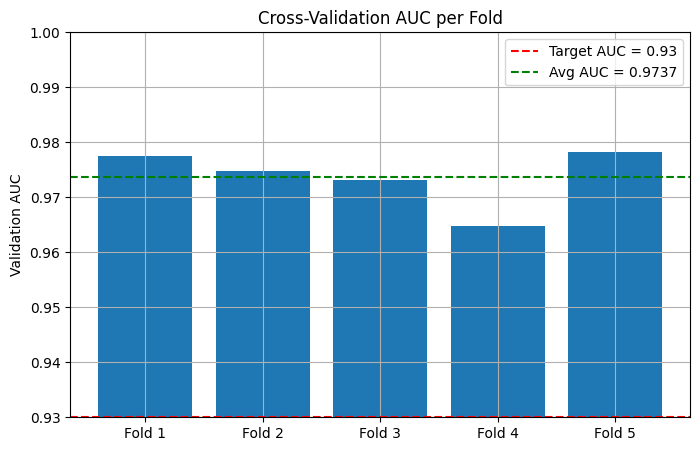

In [8]:
fold_aucs = [0.9775, 0.9748, 0.9732, 0.9648, 0.9782]
average_auc = np.mean(fold_aucs)

plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), fold_aucs, tick_label=[f'Fold {i}' for i in range(1, 6)])
plt.axhline(y=0.93, color='r', linestyle='--', label=f'Target AUC = {TARGET_AUC}')
plt.axhline(y=average_auc, color='g', linestyle='--', label=f'Avg AUC = {average_auc:.4f}')
plt.ylim(0.93, 1.0)
plt.ylabel('Validation AUC')
plt.title('Cross-Validation AUC per Fold')
plt.legend()
plt.grid(True)
plt.show()

# Entrenamiento

In [7]:
train_df, val_df = train_test_split(df_train, test_size=0.1, stratify=df_train["class"], random_state=RANDOM_STATE)

In [8]:
# Uso de funciones
loader_train = generar_loader(train_df["texto_bert"].tolist(), train_df["class"].tolist(), shuffle=True)
loader_val = generar_loader(val_df["texto_bert"].tolist(), val_df["class"].tolist())

In [9]:
model_final = RobertaClassifier(unfreeze_layers=["encoder.layer.11", "encoder.layer.10"]).to(DEVICE)
optimizer = AdamW(model_final.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()
scheduler_final = ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.5, patience=2)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Training loop
best_auc = 0
patience_counter = 0
train_loss_vals, val_auc_vals = [], []

for epoch in range(NUM_EPOCHS):
    model_final.train()
    
    total_loss = 0

    for batch in tqdm(loader_train, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model_final(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        total_loss += loss.item()
        
    
    avg_loss_train = total_loss / len(loader_train)    
    train_loss_vals.append(avg_loss_train)
    
    model_final.eval()
    val_trues, val_preds = [], []
    with torch.no_grad():
        for batch in loader_val:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels =  batch["labels"].cpu().numpy()
            outputs = model_final(input_ids, attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            val_preds.extend(probs)
            val_trues.extend(labels)

    auc_val = roc_auc_score(val_trues, val_preds)
    f1_val = f1_score(val_trues, np.array(val_preds) > 0.5)
    val_auc_vals.append(auc_val)
    scheduler_final.step(auc_val)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss_train:.4f}, Validation AUC = {auc_val:.4f}, F1 Score = {f1_val:.4f}")

    if auc_val > best_auc:
        best_auc = auc_val
        patience_counter = 0
        torch.save(model_final.state_dict(), "../../models/final_best_model.pt")
        print("Modelo guardado!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping")
            break

Epoch 1: 100%|██████████| 85/85 [01:32<00:00,  1.09s/it]


Epoch 1: Train Loss = 0.2225, Validation AUC = 0.9457, F1 Score = 0.9045
Modelo guardado!


Epoch 2: 100%|██████████| 85/85 [01:55<00:00,  1.36s/it]


Epoch 2: Train Loss = 0.1831, Validation AUC = 0.9568, F1 Score = 0.9167
Modelo guardado!


Epoch 3: 100%|██████████| 85/85 [01:49<00:00,  1.29s/it]


Epoch 3: Train Loss = 0.1458, Validation AUC = 0.9600, F1 Score = 0.9222
Modelo guardado!


Epoch 4: 100%|██████████| 85/85 [01:47<00:00,  1.27s/it]


Epoch 4: Train Loss = 0.1027, Validation AUC = 0.9598, F1 Score = 0.9277


Epoch 5: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s]


Epoch 5: Train Loss = 0.0748, Validation AUC = 0.9607, F1 Score = 0.9333
Modelo guardado!


Epoch 6: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s]


Epoch 6: Train Loss = 0.0516, Validation AUC = 0.9571, F1 Score = 0.9136


Epoch 7: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s]


Epoch 7: Train Loss = 0.0376, Validation AUC = 0.9604, F1 Score = 0.9333


Epoch 8: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s]


Epoch 8: Train Loss = 0.0297, Validation AUC = 0.9598, F1 Score = 0.9202


Epoch 9: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s]


Epoch 9: Train Loss = 0.0208, Validation AUC = 0.9604, F1 Score = 0.9398


Epoch 10: 100%|██████████| 85/85 [01:17<00:00,  1.09it/s]


Epoch 10: Train Loss = 0.0189, Validation AUC = 0.9595, F1 Score = 0.9202
Early stopping


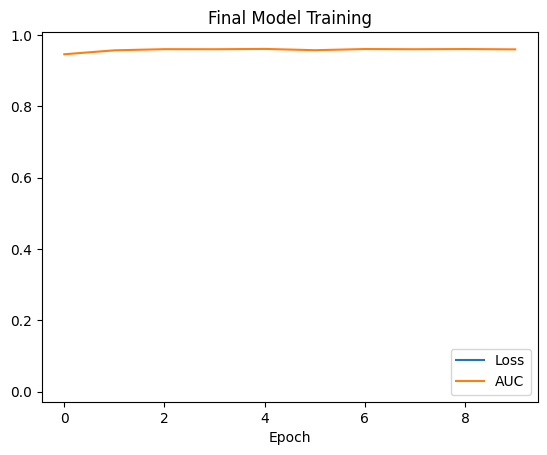

In [12]:
# Plot training performance
plt.figure()
plt.plot(avg_loss_train, label="Loss")
plt.plot(val_auc_vals, label="AUC")
plt.xlabel("Epoch")
plt.title("Final Model Training")
plt.legend()
plt.show()

# Prueba

In [14]:
df_test = pd.read_csv("../../data/ds_BETO_TEST.csv")
texts_test = df_test["texto_bert"].tolist()
labels_test = df_test["class"].tolist()

In [ ]:
model_final.load_state_dict(torch.load("../../models/final_best_model.pt"))
model_final.eval()

RobertaClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [16]:
y_true, y_probs, y_pred = obtener_probs(texts_test, labels_test, model_final)
reporte = classification_report(y_true, y_pred)

print("Reporte Clasificación RoBERTa:")
print(reporte)

Reporte Clasificación RoBERTa:
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       116
         1.0       0.90      0.93      0.91       134

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



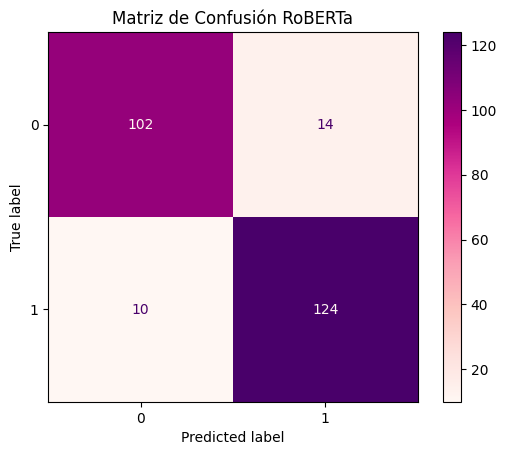

In [17]:
cm, disp = crear_matriz_confusion(y_true, y_pred)
disp.plot(cmap='RdPu')
plt.title("Matriz de Confusión RoBERTa")
plt.show()

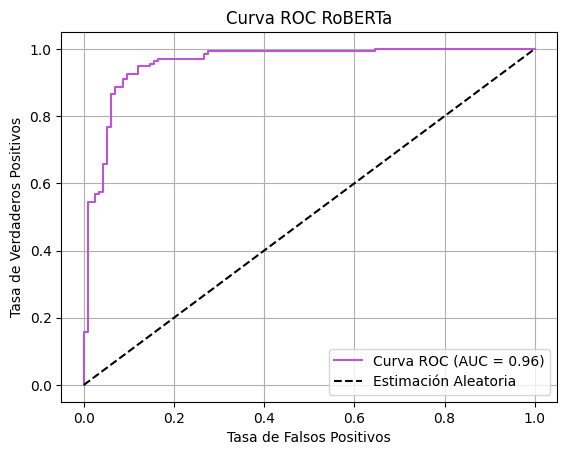

In [18]:
# Predicciones de probabilidad (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_true, y_probs)

# Gráfica ROC
plt.figure()
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC RoBERTa")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [19]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR * 100):.4f}")

AUC: 95.8698
TPR (True Positive Rate): 92.5373
FPR (False Positive Rate): 12.0690
